In [59]:

import numpy as np
import pandas as pd
import ast
import string 
import matplotlib.pyplot as plt


In [3]:
res_2_models_ba = pd.read_csv('data_SRL/res_2_models_ba.csv')
res_2_models_kk1 = pd.read_csv('data_SRL/res_2_models_kk1.csv')
res_2_models_kk2 = pd.read_csv('data_SRL/res_2_models_kk2.csv')
res_2_models_tt = pd.read_csv('data_SRL/res_2_models_tt.csv')



In [12]:
res_2_models_kk1.columns = ['0','FrameNet', 'BertSRL','preds', 'sentence','sent_len']
res_2_models_kk2.columns = ['0','FrameNet', 'BertSRL','preds', 'sentence','sent_len']
res_2_models_tt.columns = ['0','FrameNet', 'BertSRL','preds', 'sentence','sent_len']
res_2_models_ba.columns = ['0','FrameNet', 'BertSRL','preds', 'sentence','sent_len']

In [83]:
def get_args(verbs):  
    srl = []
    predicats = []
    for roles in verbs:
        verb = roles['verb']
        args = list(roles['description'].values())
#         if verb in args:
#             args.remove(verb)
        srl.append(args)
        predicats.append(verb)
    return srl, predicats

def drop_punkt(word):
    word=str(word)
    punc = string.punctuation
    for p in punc:
        word = word.replace(p,'')
    return word

def count_verbs(data): # Подсчет с наличием хотябы одного предиката из FrameNet
    data_FrameNet, data_BertSRL = data.loc[:,'FrameNet'],data.loc[:,'BertSRL']
    predicats = [0 for _ in range(data_FrameNet.shape[0])]
#     arguments = [0 for _ in range(data_kk_1.shape[0])]

    for i in range(data_FrameNet.shape[0]):
        try:
            verbs_1 = ast.literal_eval(data_FrameNet.loc[i])['verbs']
            a_1, v_1 = get_args(verbs_1)
#             print('FrameNet',a_1, v_1)
            
            verbs_2 = ast.literal_eval(data_BertSRL.loc[i])['verbs']
            a_2, v_2 = get_args(verbs_2)
#             print('BERT',a_2, v_2) 
#             print(ast.literal_eval(data_kk_1.loc[i])['words'])
#             print()
            # Смотрим соответствие глаголов
            for verb1 in v_1:
#                 print()
#                 print('Frame', verb1)
                for verb2 in v_2:
#                     print('bert', verb2)
                    if drop_punkt(verb1) in verb2:
                        predicats[i] = 1
#                         print(True)
                        break
                    else:
                        continue    

        except:
            continue
        data['preds'] = predicats
    return data


def calc_score(result_srl_kk,x):

    res_kk[res_kk.preds_kk == 1].sent_len.hist()
    
    score = res_kk[res_kk.sent_len <= x].preds_kk.mean()
#     print('score: ', score)
    res = res_kk[res_kk.sent_len <= x]
    return res, score

In [86]:
# attention threshold = 0.1e-00

preds_kk1 = count_verbs(res_2_models_kk1)
preds_kk2 = count_verbs(res_2_models_kk2)
preds_tt = count_verbs(res_2_models_tt)
preds_ba = count_verbs(res_2_models_ba)

print('kk1:', np.mean(preds_kk1['preds']))
print('kk2:', np.mean(preds_kk2['preds']))
print('tt:', np.mean(preds_tt['preds']))
print('ba:', np.mean(preds_ba['preds']))

kk1: 0.5422993492407809
kk2: 0.5183098591549296
tt: 0.41569767441860467
ba: 0.2847222222222222


In [102]:
print('kk1:', np.mean(preds_kk1['preds'][preds_kk1.sent_len <= preds_kk1.sent_len.mean()]))
print('kk2:', np.mean(preds_kk2['preds'][preds_kk2.sent_len <= preds_kk2.sent_len.mean()]))
print('tt:', np.mean(preds_tt['preds'][preds_tt.sent_len <= preds_tt.sent_len.mean()]))
print('ba:', np.mean(preds_ba['preds'][preds_ba.sent_len <= preds_ba.sent_len.mean()]))

kk1: 0.6007751937984496
kk2: 0.5656108597285068
tt: 0.4712041884816754
ba: 0.31097560975609756


In [148]:
def count_verbs2(res_2_models_ba): #Подсчет с полным наличием предикатов и аргументов с FrameNet
    for i in range(len(res_2_models_ba)):
        try:
            # По предикатам
            verb1 = set()
            verb2 = set()

            for j in range(len(ast.literal_eval(res_2_models_ba.loc[i, 'FrameNet'])['verbs'])):
                verb1.add(ast.literal_eval(res_2_models_ba.loc[i, 'FrameNet'])['verbs'][j]['verb'])
            for j in range(len(ast.literal_eval(res_2_models_ba.loc[i, 'BertSRL'])['verbs'])):
                verb2.add(ast.literal_eval(res_2_models_ba.loc[i, 'BertSRL'])['verbs'][j]['verb'])

#             print('BEFORE',verb1, verb2)

            verb1 = set(drop_punkt(verb1).split())
            verb2 = set(drop_punkt(verb2).split())
#             print('AFTER',verb1, verb2)

            if (len(verb1.intersection(verb2)) != 0) & (verb1 != ""):
                res_2_models_ba.loc[i, 'preds_new'] = 1
            else:
                res_2_models_ba.loc[i, 'preds_new'] = 0
                
                
            # По аргументам
            arguments1 = ast.literal_eval(res_2_models_ba.loc[i, 'FrameNet'])['verbs'][0]['description']
            args1 = set()
            for key, value in arguments1.items():
                if key != 'V':
                    args1.add(value)

            args2 = set()

            for j in range(len(ast.literal_eval(res_2_models_ba.loc[i, 'BertSRL'])['verbs'])):
                arguments2 = ast.literal_eval(res_2_models_ba.loc[i, 'BertSRL'])['verbs'][j]['description']
                for key, value in arguments2.items():
                    if key != 'V':
                        args2.add(value)
                        
#             print('BEFORE',args1, args2)

            args1 = set(drop_punkt(args1).split())
            args2 = set(drop_punkt(args2).split())
#             print('AFTER',args1, args2)

            if len(args1.intersection(args2)) != 0:
                res_2_models_ba.loc[i, 'args'] = 1
            else:
                res_2_models_ba.loc[i, 'args'] = 0

            
            
    #     print(i, 'v1: ', verb1, 'v2: ', verb2, res_2_models_ba.loc[i, 'preds_kk_new'])
    #     print(res_2_models_ba.loc[i, 'sentence'])
    #     print()
    

        except:
            pass
#         print(i, 'v1: ', verb1, 'v2: ', verb2, res_2_models_ba.loc[i, 'preds_new'])
#         print('args1: ', args1, 'args2: ', args2, res_2_models_ba.loc[i, 'args'])

    
    return res_2_models_ba

In [136]:
# res_2_models_kk1.loc[0, 'preds_new'] = 0
# res_2_models_kk2.loc[0, 'preds_new'] = 0
# res_2_models_tt.loc[0, 'preds_new'] = 0
# res_2_models_ba.loc[0, 'preds_new'] = 0

res_2_models_kk1.loc[0, 'args'] = 0
res_2_models_kk2.loc[0, 'args'] = 0
res_2_models_tt.loc[0, 'args'] = 0
res_2_models_ba.loc[0, 'args'] = 0

In [166]:
len_kk = round(preds_kk1_new[preds_kk1_new['args'] == 1].sent_len.mean())
len_tt = round(preds_tt_new[preds_tt_new['args'] == 1].sent_len.mean())
len_ba = round(preds_ba_new[preds_ba_new['args'] == 1].sent_len.mean())


print('Kazakh language')
print('Mean sentence length: ', len_kk)
print('Predicats:', round(np.mean(preds_kk1_new['preds_new'][preds_kk1_new.sent_len <= len_kk]),2))
print('Arguments:', round(np.mean(preds_kk1_new['args'][preds_kk1_new.sent_len <= len_kk]),2))
print()
print('Tatar language')
print('Mean sentence length: ', len_tt)
print('Predicats:', round(np.mean(preds_tt_new['preds_new'][preds_tt_new.sent_len <= len_tt]),2))
print('Arguments:', round(np.mean(preds_tt_new['args'][preds_tt_new.sent_len <= len_tt]),2))
print()
print('Bashkir language')
print('Mean sentence length: ', len_ba)
print('Predicats:', round(np.mean(preds_ba_new['preds_new'][preds_ba_new.sent_len <= len_ba]),2))
print('Arguments:', round(np.mean(preds_ba_new['args'][preds_ba_new.sent_len <= len_ba]),2))

Kazakh language
Mean sentence length:  21
Predicats: 0.58
Arguments: 0.85

Tatar language
Mean sentence length:  21
Predicats: 0.44
Arguments: 0.72

Bashkir language
Mean sentence length:  21
Predicats: 0.29
Arguments: 0.75


In [168]:
len_kk = round(preds_kk1_new[preds_kk1_new['args'] == 1].sent_len.mean())
len_tt = round(preds_tt_new[preds_tt_new['args'] == 1].sent_len.mean())
len_ba = round(preds_ba_new[preds_ba_new['args'] == 1].sent_len.mean())


print('Kazakh language')
print('Predicats:', round(np.mean(preds_kk1_new['preds_new']),2))
print('Arguments:', round(np.mean(preds_kk1_new['args']),2))
print()
print('Tatar language')
print('Predicats:', round(np.mean(preds_tt_new['preds_new']),2))
print('Arguments:', round(np.mean(preds_tt_new['args']),2))
print()
print('Bashkir language')
print('Predicats:', round(np.mean(preds_ba_new['preds_new']),2))
print('Arguments:', round(np.mean(preds_ba_new['args']),2))

Kazakh language
Predicats: 0.52
Arguments: 0.89

Tatar language
Predicats: 0.38
Arguments: 0.76

Bashkir language
Predicats: 0.24
Arguments: 0.76


Text(0.5, 1.0, 'Совпадения разметки предикатов относительно длины предложения')

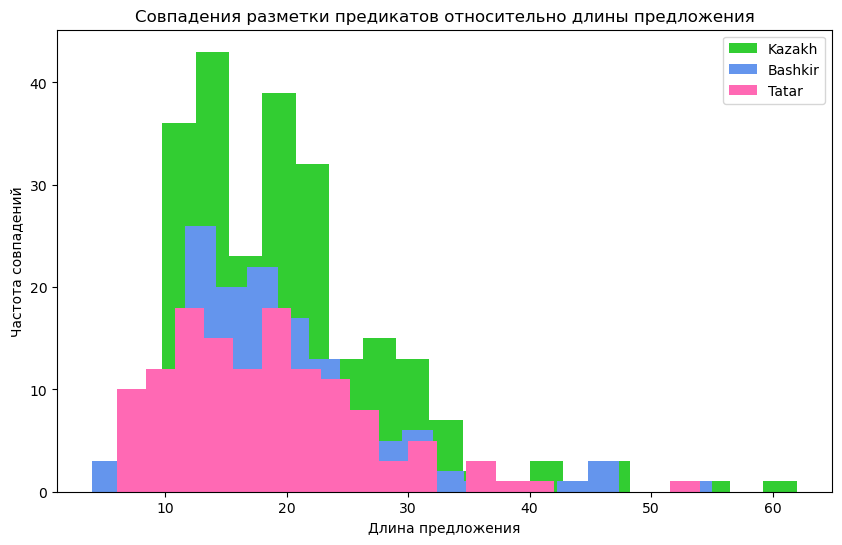

In [220]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 6))

ax.hist(preds_kk1_new[preds_kk1_new.preds_new == 1].sent_len, label='Kazakh', bins=20, color='limegreen')
ax.hist(preds_ba_new[preds_ba_new.preds_new == 1].sent_len, label='Bashkir', bins=20, color='cornflowerblue')
ax.hist(preds_tt_new[preds_tt_new.preds_new == 1].sent_len, label='Tatar', bins=20, color='hotpink')

ax.legend()
ax.set_xlabel('Длина предложения')
ax.set_ylabel('Частота совпадений')
ax.set_title('Совпадения разметки предикатов относительно длины предложения')

Text(0.5, 1.0, 'Совпадения разметки аргументов относительно длины предложения')

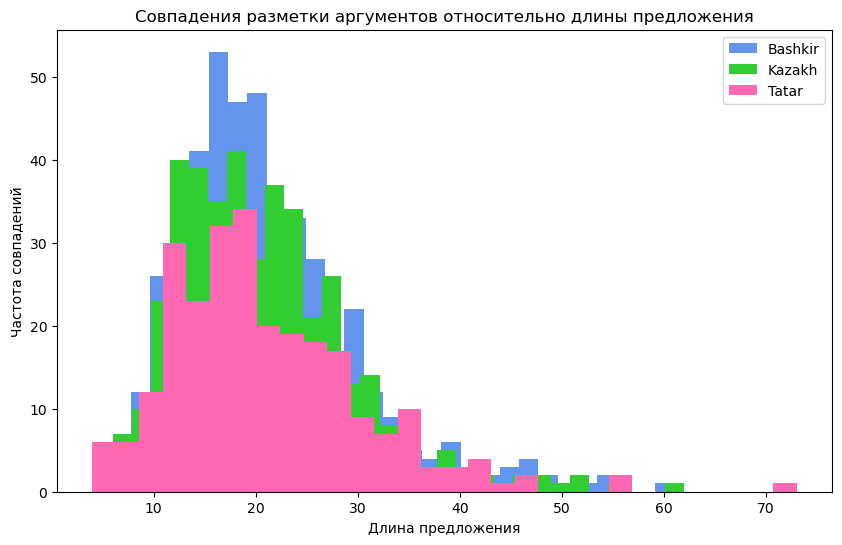

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(preds_ba_new[preds_ba_new.args == 1].sent_len, label='Bashkir', bins=30, color='cornflowerblue')
ax.hist(preds_kk1_new[preds_kk1_new.args == 1].sent_len, label='Kazakh', bins=30, color='limegreen')
# preds_kk2_new[preds_kk2_new.preds_new == 1].sent_len.hist()
ax.hist(preds_tt_new[preds_tt_new.args == 1].sent_len, label='Tatar', bins=30, color='hotpink')


ax.legend()
ax.set_xlabel('Длина предложения')
ax.set_ylabel('Частота совпадений')
ax.set_title('Совпадения разметки аргументов относительно длины предложения')